# Full-waveform inversion (FWI) with automated adjoint and checkpointing

Full-waveform inversion (FWI) is a technique in general employed to estimate the physical parameters in a subsurface region. It is a wave-equation-based seeking an optimal match between observed and computed data. The former is recorded by receivers in a real case. The latter consists of a computed data, which is obtained by solving numerically a wave equation with an forcing term representing a source of wave emission. 

## Functional to be minimised
A tradicional form to measure the difference between the observed and computed data is given by the functional (Tarantola, 1984): 
$$
    I(u, u^{obs}) = \sum_{r=0}^{N-1} \int_\Omega \left(u(c,\mathbf{x},t)- u^{obs}(c, \mathbf{x},t)\right)^2 \delta(x - x_r) \, dx
$$
where $u = u(c, \mathbf{x},t)$ and $u_{obs} = u_{obs}(c,\mathbf{x},t)$, are respectively the computed and observed data, both recorded at a finite number of receivers ($N_r$), located at the point positions $\check{\mathbf{x}} \in \Omega_{0}$, in a time interval $\tau\equiv[t_0, t_f]\subset \mathbb{R}$, where $t_0$ is the initial time and $t_f$ is the final time. The spatial domain of interest is set as $\Omega_{0}$.

An FWI problem consists in finding an optimal parameter $c$ that minimizes the functional $I(u, u^{obs})$.

## Wave equation
To have the computed data, we need first solve a wave equation. In this example, we consider the scalar acoustic wave equation using a damping term to attenate the reflections originated by the boundaries of the domain.
$$
    \frac{\partial^2 u}{\partial t^2}(\mathbf{x},t)- c^2\frac{\partial^2 u}{\partial \mathbf{x}^2} = f(\mathbf{x}_s,t) \tag{2}
$$
where $c(\mathbf{x}):\Omega_{0}\rightarrow \mathbb{R}$ is the pressure wave velocity, which is assumed here a piecewise-constant and positive. The source term $f(\mathbf{x}_s,t)$ represents a point of wave source.
The wave equation (2) satisfies the boundary conditions:
$$
    u(\mathbf{x},t) = 0, \quad \mathbf{x} \in \partial\Omega_{0}, \quad t\in\tau
$$
The acoustic wave equation should satisfy the initial conditions $u(\mathbf{x}, 0)  = 0 = u_t(\mathbf{x}, 0) = 0$. The domain $\Omega_{0}$ is illustrated at Figure. The boundaries $\partial\Omega_{i}$ with $i = 1,2,3$ are here referred to as truncated boundaries, and satisfy a null-Dirichlet boundary condition $u(\mathbf{x},t) = 0$. The boundary $\Omega_{4}$ satisfies the null-Neumann $\nabla u(\mathbf{x},t) \cdot \mathbf{n} = 0$ (free surface) boundary condition, where $\mathbf{n}$ represents the outward normal (with respect to $\partial \Omega_4$) unit vector.

To solve the wave equation, we consider the following weak form over the domain $\Omega_{0}$:
$$
    \int_{\Omega_{0}} \left(\frac{\partial^2 u}{\partial t^2}v + c^2\nabla u \cdot \nabla v\right) \, dx = \int_{\Omega_{0}} f v \, dx,
$$
for an arbitrary test function $v\in V$, where $V$ is a function space. The implementation of the weak form is given by the following Firedrake code:

In [1]:
import finat
import os
# os.environ["OMP_NUM_THREADS"] = "1"
# os.environ["PETSC_DIR"] = "/opt/petsc/firedrake"
# os.environ["PETSC_ARCH"] = "full-opt"
# os.environ["HDF5_DIR"] = "/opt/petsc/firedrake/packages"
from firedrake import *
def wave_equation_solver(c, source_function, dt, V):
    """Solves the acoustic wave equation in 2D.

    Parameters
    ----------
    c : velocity field
        The velocity field.
    source_function : firedrake.Function
        The function that models the source of the wave.
    dt : float
        The time step.
    V : firedrake.FunctionSpace
        The function space where the solution lives.

    Returns
    -------
    firedrake.LinearVariationalSolver, firedrake.Function, firedrake.Function, firedrake.Function
        Return the linear variational solver and the functions for the solution at time `n+1`, `n` and `n-1`.
        These outputs are going to be used in a time loop.
    
    Notes
    -----
    Additional information about this wave equation solver, including the discretisation and the
    linear variational problem, please refer this 
    `documentation link <https://www.firedrakeproject.org/demos/higher_order_mass_lumping.py.html>`_.
    """
    u = TrialFunction(V)
    v = TestFunction(V)

    u_np1 = Function(V) # timestep n+1
    u_n = Function(V) # timestep n
    u_nm1 = Function(V) # timestep n-1

    # quadrature rule for lumped mass matrix
    quad_rule = finat.quadrature.make_quadrature(V.finat_element.cell, V.ufl_element().degree(), "KMV")
    # time discretisation/mass matrix
    m =  (u - 2.0 * u_n + u_nm1) / Constant(dt * dt) * v * dx(scheme=quad_rule)
    # stiffness matrix
    a = c * c * dot(grad(u_n), grad(v)) * dx
    # wave source
    f = source_function * v * dx(scheme=quad_rule)
    F = m + a - f
    lhs_ = lhs(F)
    rhs_ = rhs(F)

    lin_var = LinearVariationalProblem(lhs_, rhs_, u_np1)
    solver = LinearVariationalSolver(lin_var, solver_parameters={"ksp_type": "preonly", "pc_type": "jacobi"})
    return solver, u_np1, u_n, u_nm1

firedrake:WARNING OMP_NUM_THREADS is not set or is set to a value greater than 1, we suggest setting OMP_NUM_THREADS=1 to improve performance


The wave euqation forcing $f = f(\mathbf{x}_s, t)$ represents a time-dependent wave source locate at the position $\mathbf{x}_s$, being written of the form:
$$
    f(\mathbf{x}_s,t) = r(t) \delta(\mathbf{x} - \mathbf{x}_s)
$$
where $r(t)$ is the Ricker wavelet, and $\delta(\mathbf{x} - \mathbf{x}_s)$ is the Dirac delta function. This forcing term is implemented in Firedrake as follows:

In [2]:
import numpy as np
from firedrake.__future__ import interpolate
def forcing(wavelet, parent_mesh, source_location):
    V = parent_mesh.coordinates.function_space()
    vom  = VertexOnlyMesh(parent_mesh, source_location)
    P0DG = FunctionSpace(vom, "DG", 0)
    P1DG = FunctionSpace(vom.input_ordering, "DG", 0)
    f_p1DG = Function(P1DG)
    f_p1DG.dat.data[:] = 1.0
    # f_p0DG = Cofunction(P0DG.dual())
    # f_p0DG = assemble(interpolate(f_p1DG, P0DG))
    f_p0DG = Cofunction(P0DG.dual())
    f_p0DG.dat.data[:] = wavelet
    interp = interpolate(TestFunction(V), P0DG)
    interp_T = adjoint(interp)
    interp_action = action(interp_T, f_p0DG)
    return assemble(interp_action)

The Ricker wavelet is given by:
$$
    r(t) = (1-2\pi^2f_s^2(t-t_s)^2)e^{-\pi^2f_s^2(t-t_s)^2}
$$
where $f_s$ is the dominant frequency of the wavelet, and $t_s$ is the time shift. The Ricker wavelet is implemented as follows:

In [3]:
def ricker_wavelet(t, fs, amp=1.0):
    ts = 1.5
    t0 = t - ts * np.sqrt(6.0) / (np.pi * fs)
    rw = (amp * (1.0 - (1.0 / 2.0) * (2.0 * np.pi * fs) * (2.0 * np.pi * fs) * t0 * t0)
            * np.exp(
                (-1.0 / 4.0) * (2.0 * np.pi * fs) * (2.0 * np.pi * fs) * t0 * t0
            )
        )
    return rw

## FWI execution
In this example, we consider a two dimensional domain where we want to estimate the parameter $c$ in a physical domain with the lenght of $1$ km ($L_x = 1km$) and the depth of $1$ km ($L_z = 1km$).

Below we create a dictionary containing the parameters necessary to solve the wave equation. The `model` dictionary contains contains the keys containing the basic setup to execute the acoust wave equation, and the FWI.

In addition, we create a `plot_function` used to plot the solutions and the parameter $c$ in the nexts code cells.

In [4]:
import numpy as np
%matplotlib inline
from firedrake.pyplot import tricontourf, tripcolor
import matplotlib.pyplot as plt
Lx, Lz = 1, 1
num_receivers = 10
num_sources = 1
model = {
    "source_locations": np.linspace((0.1, 0.4), (0.1, 0.6), num_sources),
    "receiver_locations": np.linspace((0.3, 0.1), (0.9, 0.1), num_receivers),
    "mesh": UnitSquareMesh(25, 25),
    "dt": 0.001,  # time step
    "final_time": 0.01,
    "functional": None,  # The functional to be used in the inversion. Must be a callable.
    "syntetic_receiver_data": None,  # The syntetic receiver data to be used in the inversion.
    "frequency_peak": 7.0,  # The dominant frequency of the source.
    "element_model": {"method": "KMV", "degree": 4, "quadrature": "KMV"},
}

def plot_function(function):
    # NBVAL_IGNORE_OUTPUT
    fig, axes = plt.subplots()
    contours = tricontourf(function, 10, axes=axes)
    fig.colorbar(contours, ax=axes, fraction=0.046, cmap="seismic")
    plt.gca().invert_yaxis()
    axes.set_aspect("equal")
    

As we mentioed above, the FWI problem consists in finding an optimal parameter $c$ that minimizes the functional $I(u, u^{obs})$, where $u^{obs}$ is the observed data. In this example, we consider this observed data as a synthetic data, which is obtained by solving the wave equation with a known parameter $c_{true}$. For the sake of simplicity, we consider the velocity model consisting of a circle in the center of the domain as shown in the next code cell.

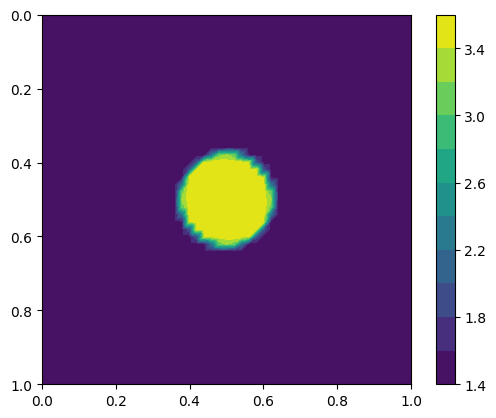

In [5]:
V = FunctionSpace(model["mesh"], model["element_model"]["method"], model["element_model"]["degree"])
x, z = SpatialCoordinate(model["mesh"])
c_true = Function(V).interpolate(2.5 + 1 * tanh(200 * (0.125 - sqrt((x - 0.5) ** 2 + (z - 0.5) ** 2))))
plot_function(c_true)

Next, we have the synthetic data recorded by the receivers on executing the wave equation with the true parameter $c_{true}$.

In [6]:
V = FunctionSpace(model["mesh"], model["element_model"]["method"], model["element_model"]["degree"])
source_function = Function(V)
solver, u_np1, u_n, u_nm1 = wave_equation_solver(c_true, source_function, model["dt"], V)
g = forcing(model["mesh"], model["source_locations"][0], V)
for t in np.arange(0, model["final_time"], model["dt"]):
    source_function.assign(g * ricker_wavelet(t, model["frequency_peak"]))
    # Call the solver object.
    solver.solve()
    # Exchange the solution at the two time-stepping levels.
    u_nm1.assign(u_n)
    u_n.assign(u_np1)
syntetic_pressure = u_np1

/Users/ddolci/tes_fire_install/firedrake/src/ufl/ufl/utils/sorting.py:84: UserWarning: Applying str() to a metadata value of type QuadratureRule, don't know if this is safe.
  warnings.warn(f"Applying str() to a metadata value of type {type(value).__name__}, "
/Users/ddolci/tes_fire_install/firedrake/src/ufl/ufl/utils/sorting.py:84: UserWarning: Applying str() to a metadata value of type QuadratureRule, don't know if this is safe.
  warnings.warn(f"Applying str() to a metadata value of type {type(value).__name__}, "


In [7]:
receiver_mesh = VertexOnlyMesh(model["mesh"], model["receiver_locations"])
P0DG = FunctionSpace(receiver_mesh, "DG", 0)
syntetic_receiver_data = assemble(interpolate(syntetic_pressure, P0DG))
model["syntetic_receiver_data"] = syntetic_receiver_data

Before starting the FWI, we implement the functional $I(u, u^{obs})$....

In [8]:
def functional(u):
    # """Compute the functional."""
    # if model["syntetic_receiver_data"] and isinstance(model["syntetic_receiver_data"], Function):
    syntetic_receiver = model["syntetic_receiver_data"]
    # else:
    #     raise ValueError("syntetic_receiver_data must be a Firedrake Function.")
    guess_receiver = assemble(interpolate(u, P0DG))
    return 0.5 * assemble(inner(guess_receiver - syntetic_receiver, guess_receiver - syntetic_receiver) * dx)

model["functional"] = functional


We then start inform the algorithmic differentiation to tape the foward solver associate to the paremeter $c$, which minimises the functional $I(u, u^{obs})$. Taping the forward solver starts when we set `continue_annotation()`.

In [9]:
from firedrake.adjoint import continue_annotation
continue_annotation()

True

<div class="alert alert-block alert-info">
<b>Note:</b> If you do not want to use checkpointing in your FWI, you can skip the cell below.
</div>

In [10]:
from checkpoint_schedules import Revolve
from firedrake.adjoint import get_working_tape
total_steps = int(model["final_time"] / model["dt"])
print(f"Total steps: {total_steps}")
tape = get_working_tape()
tape.enable_checkpointing(Revolve(total_steps -1, 7))

Total steps: 10


The initial guess for the parameter $c$ is set as a constant field as shown below.

In [28]:
from firedrake import *
import numpy as np
data_coords = np.array(
    [
        [0.0, 0.0],
    ]
)
data_vals = np.array([1.0])

# We have a set of points with corresponding data from elsewhere which vary
# from rank to rank
parent_mesh = UnitSquareMesh(100, 100, quadrilateral=True)
vom = VertexOnlyMesh(parent_mesh, data_coords, redundant=False)
P0DG = FunctionSpace(vom, "DG", 0)

# Create a P0DG function on the input ordering vertex-only mesh
P0DG_input_ordering = FunctionSpace(vom.input_ordering, "DG", 0)
point_data_input_ordering = Function(P0DG_input_ordering)

# We can safely set the values of this function, knowing that the data will
# be in the same order and on the same MPI rank as point_locations_from_elsewhere
point_data_input_ordering.dat.data_wo[:] = 1.0

# Interpolate puts this data onto the original vertex-only mesh
point_data = assemble(interpolate(point_data_input_ordering, P0DG))

/Users/ddolci/tes_fire_install/firedrake/src/firedrake/firedrake/interpolation.py:380: FutureWarning: The use of `interpolate` to perform the numerical interpolation is deprecated.
This feature will be removed very shortly.

Instead, import `interpolate` from the `firedrake.__future__` module to update
the interpolation's behaviour to return the symbolic `ufl.Interpolate` object associated
with this interpolation.

You can then assemble the resulting object to get the interpolated quantity
of interest. For example,

```
from firedrake.__future__ import interpolate
...

assemble(interpolate(expr, V))
```

Alternatively, you can also perform other symbolic operations on `interp`, such as taking
the derivative, and then assemble the resulting form.

  warnings.warn("""The use of `interpolate` to perform the numerical interpolation is deprecated.
/Users/ddolci/tes_fire_install/firedrake/src/firedrake/firedrake/interpolation.py:380: FutureWarning: The use of `interpolate` to perform the num

NameError: name 'vom' is not defined

In [12]:
def J(c):
    V = FunctionSpace(model["mesh"], model["element_model"]["method"], model["element_model"]["degree"])
    source_function = Function(V)
    solver, u_np1, u_n, u_nm1 = wave_equation_solver(c, source_function, model["dt"], V)
    time_interval = np.arange(0, model["final_time"], model["dt"])
    g = forcing(model["mesh"], model["source_locations"][0], V)
    J_val = 0.0
    for t in tape.timestepper(iter(time_interval)):
        source_function.assign(g * ricker_wavelet(t, model["frequency_peak"]))
        # Call the solver object.
        solver.solve()
        # Exchange the solution at the two time-stepping levels.
        u_nm1.assign(u_n)
        u_n.assign(u_np1)
        # functional must be callable.
        functional = model["functional"]
        J_val += functional(u_n)
    return J_val


In [14]:
tape.clear_tape()
tape.progress_bar = ProgressBar
guess_pressure = J(c)
tape.clear_tape()

Taping forward ▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢ 0/100 [0:00:00]/Users/ddolci/tes_fire_install/firedrake/src/ufl/ufl/utils/sorting.py:84: UserWarning: Applying str() to a metadata value of type QuadratureRule, don't know if this is safe.
  warnings.warn(f"Applying str() to a metadata value of type {type(value).__name__}, "
Taping forward ▣▣▣▣▣▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢ 10/100 [0:00:17]
